



# Extension 01 // Add Convolutional Layer to Neural Network 

In [0]:
# set Hyperparameters 
epochs = 10

## Load Both MNIST and CIFAR Dataset to temp-data in Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from pathlib import Path
import os
import requests
import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

os.chdir('/content/drive/My Drive')
print(os.getcwd())

# Move into primary Drive Folder
os.chdir('/content/drive/My Drive')

# Make temp-data directory and move inside
path_name = 'temp-data/'
Path("temp-data/").mkdir(parents=True, exist_ok=True)
os.chdir(path_name)
print('\nData directory created...')

print('Download starting...')
url = 'https://github.com/aobject/public-nyu-ml/blob/master/ML-Project/Data/cifar-10.p?raw=true'
target_path = 'cifar-10.p'
response = requests.get(url, stream=True)
if response.status_code == 200:
    with open(target_path, 'wb') as f:
        f.write(response.raw.read())

url = 'https://github.com/aobject/public-nyu-ml/blob/master/ML-Project/Data/mnist.p?raw=true'
target_path = 'mnist.p'
response = requests.get(url, stream=True)
if response.status_code == 200:
    with open(target_path, 'wb') as f:
        f.write(response.raw.read())
print('\nThe files in the data folder include:')
path = '.'
files = os.listdir(path)
for name in files:
    print(name)

digits = unpickle('mnist.p')
print('\nDigits data shape is {}'.format(digits['data'].shape))
cifar = unpickle('cifar-10.p')
cifar[b'data'] = cifar[b'data'][:1000]  # mabye increase to 1800 later
cifar[b'labels'] = cifar[b'labels'][:1000]
print('cifar data shape is {}'.format(cifar[b'data'].shape))

print('\nAll done, your data is ready to go!!!\n')

/content/drive/My Drive

Data directory created...
Download starting...

The files in the data folder include:
mnist.p
cifar-10.p

Digits data shape is (1797, 64)
cifar data shape is (1000, 3072)

All done, your data is ready to go!!!



## Part ( i ) // Baseline Initial Machine Learning Algorithm on Dataset I: 
## Vanilla Neural Network
## This is the example from the HW Notebook only modified to add more data collection

The base strategy we are going to start with is Neural Networks. This topic was was covered in the week 8. In this first section I will include the code given in homework 8. The performance will give us a benchmark we can work from. 

Our extension to the code in homework 8 will be to add a convolutional layers to the neural network. First, we will use a PyTorch implementation. Then, we will write our own implementation. 

Here is the Neural Network implemented in homework 8. 

### The first thing we will do is import all the libraries and prepare the data

We will be using the lower resolution MINST data set

The shape of the digits dataset:
(1797, 64)


<Figure size 432x288 with 0 Axes>

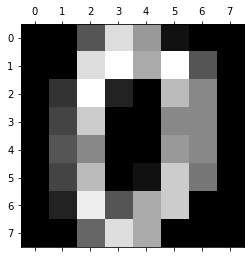

[0]
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
/test/test_9.774900
[9 4 1 8]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Starting gradient descent for 10 iterations
Epoch 0 of 10
CPU times: user 1.09 s, sys: 0 ns, total: 1.09 s
Wall time: 1.09 s


In [0]:
# Import Libraries
from sklearn.preprocessing import StandardScaler  # It is important in neural networks to scale the date
from sklearn.model_selection import train_test_split  # The standard - train/test to prevent overfitting and choose hyperparameters
from sklearn.metrics import accuracy_score # 
import numpy as np
import numpy.random as r # We will randomly initialize our weights
import matplotlib.pyplot as plt 
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, HoverTool, NumeralTickFormatter, Legend
from bokeh.io import output_notebook
output_notebook()

X = digits['data']
print("The shape of the digits dataset:") 
print(digits['data'].shape)
plt.gray()
plt.matshow(digits['images'][0])
plt.show()
y = digits.target
print(y[0:1])
print(X[0,:])

X_scale = StandardScaler()
X = X_scale.fit_transform(X)

X[0,:] # Looking the new features after scaling

#Split the data into training and test set.  60% training and %40 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

print('/test/test_{:0>3f}'.format(np.around(9.7748848488448, decimals=4)))

def convert_y_to_vect(y):
    y_vect = np.zeros((len(y), 10))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect


# convert digits to vectors
y_v_train = convert_y_to_vect(y_train)
y_v_test = convert_y_to_vect(y_test)

print(y_train[0:4])
print(y_v_train[0:4])

def f(z):
    return 1 / (1 + np.exp(-z))


def f_deriv(z):
    return f(z) * (1 - f(z))

def setup_and_init_weights(nn_structure):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1])) #Return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

def feed_forward(x, W, b):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = { } # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        # import pdb; pdb.set_trace()
        a[l+1] = f(z[l+1]) # a^(l+1) = f(z^(l+1))
    return a, z

def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * f_deriv(z_out) 


def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

def predict_y(W, b, X, n_layers):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(a[n_layers])
    return y

def train_nn(nn_structure, X_train, y_train, X_test, y_test, iter_num=100, alpha=0.25):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y_train)
    avg_cost_func = []

    loss_train_seq = []
    loss_test_seq = []
    acc_train_seq = []
    acc_test_seq = []
    train_examples = len(y_train)
    test_examples = len(y_test)

    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%1000 == 0:
            print('Epoch {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0

        loss_train = 0.0
        loss_test = 0.0
        acc_train = 0.0
        acc_test = 0.0


        for i in range(N):
            delta = {}
            # perform the feed forward pass and return the stored a and z values, to be used in the
            # gradient descent step
            a, z = feed_forward(X_train[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y_train[i,:], a[l], z[l])
                    loss_train += np.linalg.norm((y_train[i,:]-a[l]))
                    if np.argmax(a[len(nn_structure)]) == np.argmax(y_v_train[i]):
                      acc_train += 1.0
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0/N * tri_W[l])
            b[l] += -alpha * (1.0/N * tri_b[l])
        
        # Test model

        # get y prediction
        # y_pred = predict_y(W, b, X_test, 3)
        
        for i in range(test_examples):
         
            a, z = feed_forward(X_test[i, :], W, b)
            # calculate loss
            loss_test += np.linalg.norm((y_test[i,:]-a[len(nn_structure)]))
            # calculate accuracy
            if np.argmax(a[len(nn_structure)]) == np.argmax(y_v_test[i]):
                acc_test += 1
            
        # complete the average cost calculation
        loss_train_seq.append(loss_train / train_examples)
        loss_test_seq.append(loss_test / test_examples)
        acc_train_seq.append(acc_train / train_examples)
        acc_test_seq.append(acc_test / test_examples)
        cnt += 1
    return W, b, (loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq)


nn_structure = [64, 30, 10]
    
# train the NN
%time W, b, result_baseline_hwcode_mnist = train_nn(nn_structure, X_train, y_v_train, X_test, y_v_test, epochs, 0.25)

def plot_results(loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq):
    print('The test set prediction accuracy is {}%'.format(acc_test_seq[-1] * 100))
    # import pdb; pdb.set_trace()
    source = ColumnDataSource(data={
        'epoch'            : range(1, len(loss_test_seq) + 1),
        'train_loss'    : loss_train_seq,
        'test_loss'        :  loss_test_seq,
    })

    p = figure(title='MNIST Loss: NN without CNN provide in HW', plot_width=400, plot_height=400)

    p.line(x='epoch', y='train_loss', color='#329fe3', line_alpha=0.8 , line_width=2, legend_label="Train", source=source)
    p.line(x='epoch', y='test_loss', color='#e33270', line_alpha=0.8, line_width=2, legend_label="Test", source=source)
    p.legend.location = "top_right"
    p.xaxis.axis_label = 'Epochs'
    p.yaxis.axis_label = 'Loss' 

    p.add_tools(HoverTool(
        tooltips=[
                  ('Epochs', '@epoch{int}'),
                  ('Training Loss', '@train_loss{0.000 a}'),
                  ('Test Loss', '@test_loss{0.000 a}'),
        ],

        mode='mouse'
    ))

    show(p)

    source = ColumnDataSource(data={
        'epoch'            : range(1, len(acc_train_seq) + 1),
        'train_acc'    : np.array(acc_train_seq),
        'test_acc'        :  np.array(acc_test_seq),
    })

    p = figure(title='MNIST Accuracy: NN without CNN provided in HW', plot_width=400, plot_height=400)

    p.line(x='epoch', y='train_acc', color='#329fe3', line_alpha=0.8 , line_width=2, legend_label="Train", source=source)
    p.line(x='epoch', y='test_acc', color='#e33270', line_alpha=0.8, line_width=2, legend_label="Test", source=source)
    p.legend.location = "bottom_right"
    p.xaxis.axis_label = 'Epochs'
    p.yaxis.axis_label = 'Accuracy' 
    p.yaxis.formatter = NumeralTickFormatter(format='0 %')

    p.add_tools(HoverTool(
        tooltips=[
                  ('Epochs', '@epoch{int}'),
                  ('Training Accuracy', '@{train_acc}{%0.2f}'),
                  ('Test Accuracy', '@{test_acc}{%0.2f}'),
        ],

        mode='mouse'
    ))

    show(p)



In [0]:
loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq = result_baseline_hwcode_mnist

plot_results(loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq)


The test set prediction accuracy is 13.212795549374132%


## Part ( i ) Continued: A Better Baseline
## Baseline MNIST Neural Network implimented to PyTorch without CNN Layers

In addition, I have implimented a baseline implimentation of a Neural Network without CNN Layers

In [0]:
# Import modules
import torch
import numpy as np
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import load_digits # The MNIST data set is in scikit learn data set
from sklearn.preprocessing import StandardScaler  # It is important in neural networks to scale the date
from sklearn.model_selection import train_test_split  # The standard - train/test to prevent overfitting and choose hyperparameters
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.models.formatters import NumeralTickFormatter
from bokeh.io import output_notebook
output_notebook()

class MNISTDataset(Dataset):
    def __init__(self, data, label):
        self.data = data.reshape((-1,8,8,1))
        self.label = label

    def __len__(self):
        return len(self.label)

    def __getitem__(self, item):

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = self.data[item].transpose((2, 0, 1))
        image = torch.from_numpy(image)
        target = self.label[item]
        target = torch.from_numpy(target)
        return (image, target)


class MNIST(nn.Module):

    # Our batch shape for input x is (1, 8, 8)

    def __init__(self):
        super(MNIST, self).__init__()

        self.fc1 = nn.Linear(64, 30)
        self.fc2 = nn.Linear(30, 10)

    def forward(self, x):

        x = x.view(-1, 8 * 8)

        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))

        return x


def scorecard(output, labels):
    score = 0
    score = np.where(np.argmax(output, axis=1) == np.argmax(labels, axis=1), 1, 0)
    score = np.sum(score)
    return score



def trainModel(model, batch_size, num_epochs, learning_rate):
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", num_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)

    X = digits['data']
    y = digits['target']

    X_scale = StandardScaler()
    X = X_scale.fit_transform(X)

    # Split the data into training and test set.  60% training and %40 test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

    def convert_y_to_vect(y):
        y_vect = np.zeros((len(y), 10))
        for i in range(len(y)):
            y_vect[i, y[i]] = 1
        return y_vect

    # convert digits to vectors
    y_v_train = convert_y_to_vect(y_train)
    y_v_test = convert_y_to_vect(y_test)

    train_dataset = MNISTDataset(X_train, y_v_train)
    test_dataset = MNISTDataset(X_test, y_v_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    torch.manual_seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(0)
    mean, std = (0.5,), (0.5,)

    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    model = model.double()

    loss_train_seq = []
    loss_test_seq = []
    acc_train_seq = []
    acc_test_seq = []

    for i in range(num_epochs):
        loss_train = 0.0
        loss_test = 0.0
        acc_train = 0.0
        acc_test = 0.0
        train_examples = 0
        test_examples = 0

        for j, (images, labels) in enumerate(train_loader, 0):
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            acc_train += scorecard(output.detach().numpy(), labels.detach().numpy())
            train_examples += len(labels)
            loss_train += loss.detach().numpy()
            loss.backward()
            optimizer.step()


        for images, labels in test_loader:

            with torch.no_grad():
                output = model(images)

                loss = criterion(output, labels)
                loss_test += loss.detach().numpy()
                acc_test += scorecard(output.detach().numpy(), labels.detach().numpy())
                test_examples += len(labels)
        loss_train_seq.append(loss_train / train_examples)
        loss_test_seq.append(loss_test / test_examples)
        acc_train_seq.append(acc_train / train_examples)
        acc_test_seq.append(acc_test / test_examples)
        print('Epoch {} with test loss {} and test accuracy {}\n\n'.format(i, (loss_test / test_examples),(acc_test / test_examples) ))

    return (loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq)


def plot_results(loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq):
    print('The test set prediction accuracy is {}%'.format(acc_test_seq[-1] * 100))
    source = ColumnDataSource(data={
        'epoch'            : range(1, len(loss_test_seq) + 1),
        'train_loss'    : loss_train_seq,
        'test_loss'        :  loss_test_seq,
    })

    p = figure(title='MNIST Loss: Baseline without CNN', plot_width=400, plot_height=400)

    p.line(x='epoch', y='train_loss', color='#329fe3', line_alpha=0.8 , line_width=2, legend_label="Train", source=source)
    p.line(x='epoch', y='test_loss', color='#e33270', line_alpha=0.8, line_width=2, legend_label="Test", source=source)
    p.legend.location = "top_right"
    p.xaxis.axis_label = 'Epochs'
    p.yaxis.axis_label = 'Loss' 

    p.add_tools(HoverTool(
        tooltips=[
                  ('Epochs', '@epoch{int}'),
                  ('Training Loss', '@train_loss{0.000 a}'),
                  ('Test Loss', '@test_loss{0.000 a}'),
        ],

        mode='mouse'
    ))

    show(p)

    source = ColumnDataSource(data={
        'epoch'            : range(1, len(acc_train_seq) + 1),
        'train_acc'    : np.array(acc_train_seq),
        'test_acc'        :  np.array(acc_test_seq),
    })

    p = figure(title='MNIST Accuracy: Baseline without CNN', plot_width=400, plot_height=400)

    p.line(x='epoch', y='train_acc', color='#329fe3', line_alpha=0.8 , line_width=2, legend_label="Train", source=source)
    p.line(x='epoch', y='test_acc', color='#e33270', line_alpha=0.8, line_width=2, legend_label="Test", source=source)
    p.legend.location = "bottom_right"
    p.xaxis.axis_label = 'Epochs'
    p.yaxis.axis_label = 'Accuracy' 
    p.yaxis.formatter = NumeralTickFormatter(format='0 %')

    p.add_tools(HoverTool(
        tooltips=[
                  ('Epochs', '@epoch{int}'),
                  ('Training Accuracy', '@{train_acc}{%0.2f}'),
                  ('Test Accuracy', '@{test_acc}{%0.2f}'),
        ],

        mode='mouse'
    ))

    show(p)

batch_size = 1
learning_rate = 0.01
num_epochs = epochs

model = MNIST()

%time result_baseline_pytorch_mnist = trainModel(model, batch_size, num_epochs, learning_rate)
loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq = result_baseline_pytorch_mnist





===== HYPERPARAMETERS =====
batch_size= 1
epochs= 10
learning_rate= 0.01
Epoch 0 with test loss 0.11931050389482592 and test accuracy 0.19749652294853964


Epoch 1 with test loss 0.09827424124553616 and test accuracy 0.23922114047287898


Epoch 2 with test loss 0.09280758870724064 and test accuracy 0.2753824756606398


Epoch 3 with test loss 0.0906011669097619 and test accuracy 0.3282336578581363


Epoch 4 with test loss 0.08945724149802668 and test accuracy 0.3560500695410292


Epoch 5 with test loss 0.0887483191893164 and test accuracy 0.3866481223922114


Epoch 6 with test loss 0.0882419257004654 and test accuracy 0.41307371349095967


Epoch 7 with test loss 0.08783633190535572 and test accuracy 0.43115438108484005


Epoch 8 with test loss 0.08748145396486484 and test accuracy 0.44923504867872044


Epoch 9 with test loss 0.087150284718876 and test accuracy 0.47009735744089015


CPU times: user 8.18 s, sys: 435 ms, total: 8.61 s
Wall time: 8.74 s


In [0]:
plot_results(loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq)

The test set prediction accuracy is 47.009735744089014%


## Part ( ii ) // Convolutional Neural Network Extension Using Library on Dataset I

We will be using the function:

**torch.nn.Conv2d**(in_channels, out_channels, kernel_size, stride, padding) – applies convolution

The function applies a 2D convolution over an input signal composed of several input planes. 

In the simplext case, the output values of the layer with input size 
$ (N,C_{in},H,W) $ and output $(N,C_{out},H_{out},W_{out})$ can be precesely described as: 

$$ out(N_i,C_{out_j}=bias(C_{out_j})+\Sigma^{C_{in}-1}_{k=0} weight(C_{out_j},k)\star input(N_i,k)$$

were $\star$ is the valid 2D cross-correlation operator, $N$ is the batch size, $C$ denotes a number of channels, $H$ is a height of input planes in pixels, and $W$ is width in pixels. 

The documentation is online [here](https://pytorch.org/docs/stable/nn.html#conv2d).


### 1) First, we import the library including torch

In [0]:
# Import modules
import torch
import numpy as np
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler  # It is important in neural networks to scale the date
from sklearn.model_selection import train_test_split  # The standard - train/test to prevent overfitting and choose hyperparameters
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import output_notebook
output_notebook()


In [0]:
def plot_results(loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq):
    print('The test set prediction accuracy is {}%'.format(acc_test_seq[-1] * 100))
    # import pdb; pdb.set_trace()
    source = ColumnDataSource(data={
        'epoch'            : range(1, len(loss_test_seq) + 1),
        'train_loss'    : loss_train_seq,
        'test_loss'        :  loss_test_seq,
    })

    p = figure(title='MNIST Loss: With PyTorch CNN', plot_width=400, plot_height=400)

    p.line(x='epoch', y='train_loss', color='#329fe3', line_alpha=0.8 , line_width=2, legend_label="Train", source=source)
    p.line(x='epoch', y='test_loss', color='#e33270', line_alpha=0.8, line_width=2, legend_label="Test", source=source)
    p.legend.location = "top_right"
    p.xaxis.axis_label = 'Epochs'
    p.yaxis.axis_label = 'Loss' 

    p.add_tools(HoverTool(
        tooltips=[
                  ('Epochs', '@epoch{int}'),
                  ('Training Loss', '@train_loss{0.000 a}'),
                  ('Test Loss', '@test_loss{0.000 a}'),
        ],

        mode='mouse'
    ))

    show(p)

    source = ColumnDataSource(data={
        'epoch'            : range(1, len(acc_train_seq) + 1),
        'train_acc'    : np.array(acc_train_seq),
        'test_acc'        :  np.array(acc_test_seq),
    })

    p = figure(title='MNIST Accuracy: With PyTorch CNN', plot_width=400, plot_height=400)

    p.line(x='epoch', y='train_acc', color='#329fe3', line_alpha=0.8 , line_width=2, legend_label="Train", source=source)
    p.line(x='epoch', y='test_acc', color='#e33270', line_alpha=0.8, line_width=2, legend_label="Test", source=source)
    p.legend.location = "bottom_right"
    p.xaxis.axis_label = 'Epochs'
    p.yaxis.axis_label = 'Accuracy' 
    p.yaxis.formatter = NumeralTickFormatter(format='0 %')

    p.add_tools(HoverTool(
        tooltips=[
                  ('Epochs', '@epoch{int}'),
                  ('Training Accuracy', '@{train_acc}{%0.2f}'),
                  ('Test Accuracy', '@{test_acc}{%0.2f}'),
        ],

        mode='mouse'
    ))

    show(p)

### 2) Create a custom Dataset class to manage the creation, incrementing, formatting, and calling of items. 

In [0]:

class MNISTDataset(Dataset):
    def __init__(self, data, label):
        self.data = data.reshape((-1,8,8,1))
        self.label = label

    def __len__(self):
        return len(self.label)

    def __getitem__(self, item):

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = self.data[item].transpose((2, 0, 1))
        image = torch.from_numpy(image)
        target = self.label[item]
        target = torch.from_numpy(target)
        return (image, target)

### 3) Create a child class of the nn.Module. This will establish the functional architecture of our neural network model. 

In [0]:

class MNIST(nn.Module):

    # Our batch shape for input x is (1, 8, 8)

    def __init__(self):
        super(MNIST, self).__init__()

        # Input channels = 1, output channels = 18
        self.conv1 = torch.nn.Conv2d(1, 18, kernel_size=3, stride=1, padding=1)
        # self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(18 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = x.view(-1, 18 * 8 * 8)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)

        return x


### 4) We will need a helper function to check the accuracy of our model's predictions. 

In [0]:
def scorecard(output, labels):
    score = 0
    score = np.where(np.argmax(output, axis=1) == np.argmax(labels, axis=1), 1, 0)
    # for i in range(len(output)):
    #     if np.argmax(output[i,:], axis=1) == np.argmax(labels[i,:], axis=1):
    #         score += 1
    score = np.sum(score)
    return score

### 5) Define the training function

In [0]:

def trainModel(model, batch_size, num_epochs, learning_rate):
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", num_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)

    X = digits['data']
    y = digits['target']

    class Scaler():
      def __init__(self, training_data):
        self.u = np.mean(training_data)
        self.s = np.std(training_data)

      def scale_data(self, in_data):
        return (in_data - self.u) / self.s

    X_scale = Scaler(X)
    X = X_scale.scale_data(X)

    def split(in_X, in_y, percentage_test):
        data_size = len(in_y)
        order = np.arange(0, data_size, dtype=int)
        np.random.shuffle(order)
        out_X = in_X[order]
        out_y = np.array(in_y)[order].tolist()
        split = int(np.rint(data_size * percentage_test))
        return in_X[split:], in_X[0:split], in_y[split:], in_y[0:split]

    # Split the data into training and test set.  60% training and %40 test
    X_train, X_test, y_train, y_test = split(X, y, 0.4)

    def convert_y_to_vect(y):
        y_vect = np.zeros((len(y), 10))
        for i in range(len(y)):
            y_vect[i, y[i]] = 1
        return y_vect

    # convert digits to vectors
    y_v_train = convert_y_to_vect(y_train)
    y_v_test = convert_y_to_vect(y_test)

    train_dataset = MNISTDataset(X_train, y_v_train)
    test_dataset = MNISTDataset(X_test, y_v_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    torch.manual_seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(0)
    mean, std = (0.5,), (0.5,)

    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    model = model.double()

    loss_train_seq = []
    loss_test_seq = []
    acc_train_seq = []
    acc_test_seq = []

    for i in range(num_epochs):
        loss_train = 0.0
        loss_test = 0.0
        acc_train = 0.0
        acc_test = 0.0
        train_examples = 0
        test_examples = 0

        for j, (images, labels) in enumerate(train_loader, 0):
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            acc_train += scorecard(output.detach().numpy(), labels.detach().numpy())
            train_examples += len(labels)
            loss_train += loss.detach().numpy()
            loss.backward()
            optimizer.step()


        for images, labels in test_loader:

            with torch.no_grad():
                output = model(images)

                loss = criterion(output, labels)
                loss_test += loss.detach().numpy()
                acc_test += scorecard(output.detach().numpy(), labels.detach().numpy())
                test_examples += len(labels)
        loss_train_seq.append(loss_train / train_examples)
        loss_test_seq.append(loss_test / test_examples)
        acc_train_seq.append(acc_train / train_examples)
        acc_test_seq.append(acc_test / test_examples)
        print('Epoch {} with test loss {} and test accuracy {}\n\n'.format(i, (loss_test / test_examples),(acc_test / test_examples) ))

    return (loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq)


### 6) Set the hyperparameters, create the model, and train the model

In [0]:
batch_size = 1
learning_rate = 0.01
num_epochs = epochs

model = MNIST()

%time result_cnn_pytorch_mnist = trainModel(model, batch_size, num_epochs, learning_rate)
loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq = result_cnn_pytorch_mnist

===== HYPERPARAMETERS =====
batch_size= 1
epochs= 10
learning_rate= 0.01
Epoch 0 with test loss 5.854927771327634 and test accuracy 0.6467315716272601


Epoch 1 with test loss 5.851489956125668 and test accuracy 0.8094575799721836


Epoch 2 with test loss 5.849930990632928 and test accuracy 0.8497913769123783


Epoch 3 with test loss 5.849005385692469 and test accuracy 0.8678720445062587


Epoch 4 with test loss 5.848362359140587 and test accuracy 0.8762169680111266


Epoch 5 with test loss 5.847873934405674 and test accuracy 0.8929068150208623


Epoch 6 with test loss 5.847482354945739 and test accuracy 0.8915159944367177


Epoch 7 with test loss 5.847157046891048 and test accuracy 0.8956884561891516


Epoch 8 with test loss 5.846879456086772 and test accuracy 0.9012517385257302


Epoch 9 with test loss 5.846638019353072 and test accuracy 0.9054242002781642


CPU times: user 49.4 s, sys: 1.39 s, total: 50.8 s
Wall time: 17.9 s


### 7) Visualize the results

In [0]:


plot_results(loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq)

The test set prediction accuracy is 90.54242002781642%


## Part ( iii ) Baseline PyTorch Neural Network Without Convolution on Dataset II

In [0]:
# Import Libraries
from sklearn.metrics import accuracy_score #
import numpy as np
import numpy.random as r # We will randomly initialize our weights
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, HoverTool, NumeralTickFormatter
from bokeh.io import output_notebook
output_notebook()
import pickle

import torch
import pickle
import numpy as np
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.models.formatters import NumeralTickFormatter
from bokeh.io import output_notebook
output_notebook()

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

class MNISTDataset(Dataset):
    def __init__(self, data, label):
        self.data = data.reshape((-1, 32, 32, 3))
        self.label = label

    def __len__(self):
        return len(self.label)

    def __getitem__(self, item):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = self.data[item].transpose((2, 0, 1))
        image = torch.from_numpy(image)
        target = self.label[item]
        target = torch.from_numpy(target)
        return (image, target)


class MNIST(nn.Module):

    # Our batch shape for input x is (1, 8, 8)

    def __init__(self):
        super(MNIST, self).__init__()

        self.fc1 = nn.Linear(3072, 30)
        self.fc2 = nn.Linear(30, 10)

    def forward(self, x):

        x = x.view(-1, 32 * 32 * 3)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))

        return x


def scorecard(output, labels):
    score = 0
    score = np.where(np.argmax(output, axis=1) == np.argmax(labels, axis=1), 1, 0)
    score = np.sum(score)
    return score

def trainModel(model, batch_size, num_epochs, learning_rate):
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", num_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)

    X = cifar[b'data']
    y = cifar[b'labels']

    class Scaler():
      def __init__(self, training_data):
        self.u = np.mean(training_data)
        self.s = np.std(training_data)

      def scale_data(self, in_data):
        return (in_data - self.u) / self.s

    X_scale = Scaler(X)
    X = X_scale.scale_data(X)

    def split(in_X, in_y, percentage_test):
        data_size = len(in_y)
        order = np.arange(0, data_size, dtype=int)
        np.random.shuffle(order)
        out_X = in_X[order]
        out_y = np.array(in_y)[order].tolist()
        split = int(np.rint(data_size * percentage_test))
        return in_X[split:], in_X[0:split], in_y[split:], in_y[0:split]

    # Split the data into training and test set.  60% training and %40 test
    X_train, X_test, y_train, y_test = split(X, y, 0.4)

    def convert_y_to_vect(y):
        y_vect = np.zeros((len(y), 10))
        for i in range(len(y)):
            y_vect[i, y[i]] = 1
        return y_vect

    # convert digits to vectors
    y_v_train = convert_y_to_vect(y_train)
    y_v_test = convert_y_to_vect(y_test)

    train_dataset = MNISTDataset(X_train, y_v_train)
    test_dataset = MNISTDataset(X_test, y_v_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    torch.manual_seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(0)
    mean, std = (0.5,), (0.5,)

    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    model = model.double()

    loss_train_seq = []
    loss_test_seq = []
    acc_train_seq = []
    acc_test_seq = []

    for i in range(num_epochs):
        loss_train = 0.0
        loss_test = 0.0
        acc_train = 0.0
        acc_test = 0.0
        train_examples = 0
        test_examples = 0

        for j, (images, labels) in enumerate(train_loader, 0):
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            acc_train += scorecard(output.detach().numpy(), labels.detach().numpy())
            train_examples += len(labels)
            loss_train += loss.detach().numpy()
            loss.backward()
            optimizer.step()

        for images, labels in test_loader:
            with torch.no_grad():
                output = model(images)

                loss = criterion(output, labels)
                loss_test += loss.detach().numpy()
                acc_test += scorecard(output.detach().numpy(), labels.detach().numpy())
                test_examples += len(labels)
        loss_train_seq.append(loss_train / train_examples)
        loss_test_seq.append(loss_test / test_examples)
        acc_train_seq.append(acc_train / train_examples)
        acc_test_seq.append(acc_test / test_examples)
        print('Epoch {} with test loss {} and test accuracy {}\n\n'.format(i, (loss_test / test_examples),
                                                                            (acc_test / test_examples)))

    return (loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq)


def plot_results(loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq):
    print('The test set prediction accuracy is {}%'.format(acc_test_seq[-1] * 100))
    source = ColumnDataSource(data={
        'epoch': range(1, len(loss_test_seq) + 1),
        'train_loss': loss_train_seq,
        'test_loss': loss_test_seq,
    })

    p = figure(title='CIFAR Loss: Baseline PyTorch No CNN', plot_width=400, plot_height=400)

    p.line(x='epoch', y='train_loss', color='#329fe3', line_alpha=0.8, line_width=2, legend_label="Train",
            source=source)
    p.line(x='epoch', y='test_loss', color='#e33270', line_alpha=0.8, line_width=2, legend_label="Test",
            source=source)
    p.legend.location = "top_right"
    p.xaxis.axis_label = 'Epochs'
    p.yaxis.axis_label = 'Loss'

    p.add_tools(HoverTool(
        tooltips=[
            ('Epochs', '@epoch{int}'),
            ('Training Loss', '@train_loss{0.000 a}'),
            ('Test Loss', '@test_loss{0.000 a}'),
        ],

        mode='mouse'
    ))

    show(p)

    source = ColumnDataSource(data={
        'epoch': range(1, len(acc_train_seq) + 1),
        'train_acc': np.array(acc_train_seq),
        'test_acc': np.array(acc_test_seq),
    })

    p = figure(title='CIFAR Accuracy: Baseline PyTorch No CNN', plot_width=400, plot_height=400)

    p.line(x='epoch', y='train_acc', color='#329fe3', line_alpha=0.8, line_width=2, legend_label="Train",
            source=source)
    p.line(x='epoch', y='test_acc', color='#e33270', line_alpha=0.8, line_width=2, legend_label="Test",
            source=source)
    p.legend.location = "bottom_right"
    p.xaxis.axis_label = 'Epochs'
    p.yaxis.axis_label = 'Accuracy'
    p.yaxis.formatter = NumeralTickFormatter(format='0 %')

    p.add_tools(HoverTool(
        tooltips=[
            ('Epochs', '@epoch{int}'),
            ('Training Accuracy', '@{train_acc}{%0.2f}'),
            ('Test Accuracy', '@{test_acc}{%0.2f}'),
        ],

        mode='mouse'
    ))

    show(p)


batch_size = 1
learning_rate = 0.01
num_epochs = epochs

model = MNIST()

# % time
result_baseline_pytorch_cifar = trainModel(model, batch_size, num_epochs, learning_rate)
loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq = result_baseline_pytorch_cifar



===== HYPERPARAMETERS =====
batch_size= 1
epochs= 10
learning_rate= 0.01
Epoch 0 with test loss 0.13420532843709576 and test accuracy 0.21


Epoch 1 with test loss 0.10685104106848753 and test accuracy 0.2525


Epoch 2 with test loss 0.098001936511202 and test accuracy 0.2675


Epoch 3 with test loss 0.09402676346568203 and test accuracy 0.255


Epoch 4 with test loss 0.09185360652123707 and test accuracy 0.25


Epoch 5 with test loss 0.09050148834722976 and test accuracy 0.2525


Epoch 6 with test loss 0.08957788263412651 and test accuracy 0.25


Epoch 7 with test loss 0.08890037612990062 and test accuracy 0.2525


Epoch 8 with test loss 0.08837471453487866 and test accuracy 0.255


Epoch 9 with test loss 0.08794816428344808 and test accuracy 0.255




In [0]:

plot_results(loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq)


The test set prediction accuracy is 25.5%


## Part ( iv ) PyTorch with CNN on Dataset II



In [0]:
# Import modules
import torch
import pickle
import numpy as np
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, HoverTool, NumeralTickFormatter, Legend
from bokeh.io import output_notebook

output_notebook()

def plot_results(loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq):
    print('The test set prediction accuracy is {}%'.format(acc_test_seq[-1] * 100))
    # import pdb; pdb.set_trace()
    source = ColumnDataSource(data={
        'epoch'            : range(1, len(loss_test_seq) + 1),
        'train_loss'    : loss_train_seq,
        'test_loss'        :  loss_test_seq,
    })

    p = figure(title='CIFAR-10 Loss: With PyTorch CNN', plot_width=400, plot_height=400)

    p.line(x='epoch', y='train_loss', color='#329fe3', line_alpha=0.8 , line_width=2, legend_label="Train", source=source)
    p.line(x='epoch', y='test_loss', color='#e33270', line_alpha=0.8, line_width=2, legend_label="Test", source=source)
    p.legend.location = "top_right"
    p.xaxis.axis_label = 'Epochs'
    p.yaxis.axis_label = 'Loss'

    p.add_tools(HoverTool(
        tooltips=[
                  ('Epochs', '@epoch{int}'),
                  ('Training Loss', '@train_loss{0.000 a}'),
                  ('Test Loss', '@test_loss{0.000 a}'),
        ],

        mode='mouse'
    ))

    show(p)

    source = ColumnDataSource(data={
        'epoch'            : range(1, len(acc_train_seq) + 1),
        'train_acc'    : np.array(acc_train_seq),
        'test_acc'        :  np.array(acc_test_seq),
    })

    p = figure(title='CIFAR-10 Accuracy: With PyTorch CNN', plot_width=400, plot_height=400)

    p.line(x='epoch', y='train_acc', color='#329fe3', line_alpha=0.8 , line_width=2, legend_label="Train", source=source)
    p.line(x='epoch', y='test_acc', color='#e33270', line_alpha=0.8, line_width=2, legend_label="Test", source=source)
    p.legend.location = "bottom_right"
    p.xaxis.axis_label = 'Epochs'
    p.yaxis.axis_label = 'Accuracy'
    p.yaxis.formatter = NumeralTickFormatter(format='0 %')

    p.add_tools(HoverTool(
        tooltips=[
                  ('Epochs', '@epoch{int}'),
                  ('Training Accuracy', '@{train_acc}{%0.2f}'),
                  ('Test Accuracy', '@{test_acc}{%0.2f}'),
        ],

        mode='mouse'
    ))

    show(p)

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# TODO update shape
class CifarDataset(Dataset):
    def __init__(self, data, label):
        # Cifar-10 has 32x32x3 images
        self.data = data.reshape((-1, 32, 32, 3))
        self.label = label

    def __len__(self):
        return len(self.label)

    def __getitem__(self, item):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = self.data[item].transpose((2, 0, 1))
        image = torch.from_numpy(image)
        target = self.label[item]
        target = torch.from_numpy(target)
        return (image, target)


class CifarNN(nn.Module):

    # Our batch shape for input x is (1, 8, 8)

    def __init__(self):
        super(CifarNN, self).__init__()

        # Input channels = 3, output channels = 18, Make sure output channels is a multiple of 3 the num of input channels
        self.conv1 = torch.nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(18 * 32 * 32, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 18 * 32 * 32)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)

        return x


def scorecard(output, labels):
    score = 0
    score = np.where(np.argmax(output, axis=1) == np.argmax(labels, axis=1), 1, 0)
    score = np.sum(score)
    return score


def trainModel(model, batch_size, num_epochs, learning_rate):
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", num_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)

    X = cifar[b'data']
    y = cifar[b'labels']

    class Scaler():
      def __init__(self, training_data):
        self.u = np.mean(training_data)
        self.s = np.std(training_data)

      def scale_data(self, in_data):
        return (in_data - self.u) / self.s

    X_scale = Scaler(X)
    X = X_scale.scale_data(X)

    def split(in_X, in_y, percentage_test):
        data_size = len(in_y)
        order = np.arange(0, data_size, dtype=int)
        np.random.shuffle(order)
        out_X = in_X[order]
        out_y = np.array(in_y)[order].tolist()
        split = int(np.rint(data_size * percentage_test))
        return in_X[split:], in_X[0:split], in_y[split:], in_y[0:split]

    # Split the data into training and test set.  60% training and %40 test
    X_train, X_test, y_train, y_test = split(X, y, 0.4)

    def convert_y_to_vect(y):
        y_vect = np.zeros((len(y), 10))
        for i in range(len(y)):
            y_vect[i, y[i]] = 1
        return y_vect

    # convert digits to vectors
    y_v_train = convert_y_to_vect(y_train)
    y_v_test = convert_y_to_vect(y_test)

    train_dataset = CifarDataset(X_train, y_v_train)
    test_dataset = CifarDataset(X_test, y_v_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    mean, std = (0.5,), (0.5,)

    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    model = model.double()

    loss_train_seq = []
    loss_test_seq = []
    acc_train_seq = []
    acc_test_seq = []

    for i in range(num_epochs):
        loss_train = 0.0
        loss_test = 0.0
        acc_train = 0.0
        acc_test = 0.0
        train_examples = 0
        test_examples = 0

        for j, (images, labels) in enumerate(train_loader, 0):
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            acc_train += scorecard(output.detach().numpy(), labels.detach().numpy())
            train_examples += len(labels)
            loss_train += loss.detach().numpy()
            loss.backward()
            optimizer.step()

        for images, labels in test_loader:
            with torch.no_grad():
                output = model(images)

                loss = criterion(output, labels)
                loss_test += loss.detach().numpy()
                acc_test += scorecard(output.detach().numpy(), labels.detach().numpy())
                test_examples += len(labels)
        loss_train_seq.append(loss_train / train_examples)
        loss_test_seq.append(loss_test / test_examples)
        acc_train_seq.append(acc_train / train_examples)
        acc_test_seq.append(acc_test / test_examples)
        print('Epoch {} with test loss {} and test accuracy {}\n\n'.format(i, (loss_test / test_examples),
                                                                           (acc_test / test_examples)))

    return (loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq)


batch_size = 1
learning_rate = 0.01
num_epochs = epochs
np.random.seed(0)
torch.manual_seed(0)

model = CifarNN()

# % time
result_cnn_pytorch_cifar = trainModel(model, batch_size, num_epochs, learning_rate)
loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq = result_cnn_pytorch_cifar





===== HYPERPARAMETERS =====
batch_size= 1
epochs= 10
learning_rate= 0.01
Epoch 0 with test loss 5.866144863905143 and test accuracy 0.1825


Epoch 1 with test loss 5.86427286952264 and test accuracy 0.2325


Epoch 2 with test loss 5.863694489220274 and test accuracy 0.245


Epoch 3 with test loss 5.863538421361588 and test accuracy 0.2575


Epoch 4 with test loss 5.863575376507636 and test accuracy 0.275


Epoch 5 with test loss 5.8637155530233045 and test accuracy 0.285


Epoch 6 with test loss 5.863917026255483 and test accuracy 0.285


Epoch 7 with test loss 5.864152401751417 and test accuracy 0.3


Epoch 8 with test loss 5.864406161387458 and test accuracy 0.3


Epoch 9 with test loss 5.864664070136043 and test accuracy 0.305




In [0]:
plot_results(loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq)

The test set prediction accuracy is 30.5%


## Synopsis: Visualizations

In [0]:
def plot_results_compare_set_one(baseline, new_benchmark):
    
    loss_train_base, loss_test_base, acc_train_base, acc_test_base = baseline
    loss_train_new, loss_test_new, acc_train_new, acc_test_new = new_benchmark

    source = ColumnDataSource(data={
        'epoch'            : range(1, len(acc_test_base) + 1),
        'test_acc_base'        :  np.array(acc_test_base),
        'test_acc_new'        :  np.array(acc_test_new),
    })

    p = figure(title='MNIST Accuracy: With and Without CNN', plot_width=600, plot_height=400)

    l_van = p.line(x='epoch', y='test_acc_base', color='#329fe3', line_alpha=0.8 , line_width=2, source=source)
    l_torch = p.line(x='epoch', y='test_acc_new', color='#e33270', line_alpha=0.8, line_width=2, source=source)
    p.xaxis.axis_label = 'Epochs'
    p.yaxis.axis_label = 'Accuracy'
    p.yaxis.formatter = NumeralTickFormatter(format='0 %')
    

    p.add_tools(HoverTool(
        tooltips=[
                  ('Epochs', '@epoch{int}'),
                  ('PyTorch CNN', '@{test_acc_new}{%0.2f}'),
                  ('No CNN', '@{test_acc_base}{%0.2f}'),
                  
        ],

        mode='mouse'
    ))

    legend = Legend(items=[('No CNN', [l_van]), ('PyTorch CNN', [l_torch]),], location=(0,250))
    p.add_layout(legend, 'left')

    show(p)




In [0]:
def plot_results_compare_set_two(baseline, new_benchmark):
    
    loss_train_base, loss_test_base, acc_train_base, acc_test_base = baseline
    loss_train_new, loss_test_new, acc_train_new, acc_test_new = new_benchmark

    source = ColumnDataSource(data={
        'epoch'            : range(1, len(acc_test_base) + 1),
        'test_acc_base'        :  np.array(acc_test_base),
        'test_acc_new'        :  np.array(acc_test_new),
    })

    p = figure(title='CIFAR Accuracy: With and Without CNN', plot_width=600, plot_height=400)

    l_van = p.line(x='epoch', y='test_acc_base', color='#329fe3', line_alpha=0.8 , line_width=2, source=source)
    l_torch = p.line(x='epoch', y='test_acc_new', color='#e33270', line_alpha=0.8, line_width=2, source=source)
    p.xaxis.axis_label = 'Epochs'
    p.yaxis.axis_label = 'Accuracy'
    p.yaxis.formatter = NumeralTickFormatter(format='0 %')
    

    p.add_tools(HoverTool(
        tooltips=[
                  ('Epochs', '@epoch{int}'),
                  ('PyTorch CNN', '@{test_acc_new}{%0.2f}'),
                  ('No CNN', '@{test_acc_base}{%0.2f}'),
                  
        ],

        mode='mouse'
    ))

    legend = Legend(items=[('No CNN', [l_van]), ('PyTorch CNN', [l_torch]),], location=(0,250))
    p.add_layout(legend, 'left')

    show(p)

## Synopsis: Compare Part ( i ) and ( ii ) on Dataset I

In [0]:
plot_results_compare_set_one(result_baseline_pytorch_mnist, result_cnn_pytorch_mnist)

## Synopsis: Compare Part ( iii ) and ( iv ) on Dataset II

In [0]:
plot_results_compare_set_two(result_baseline_pytorch_cifar, result_cnn_pytorch_cifar)